# Odds to Probabilities

* **Data Source:** [https://www.kaggle.com/hugomathien/soccer](https://www.kaggle.com/hugomathien/soccer)
* **Author:** Anders Munk-Nielsen

This notebook illustrates how to convert from betting odds to implies probabilities. Essentially, it performs one of the crucial steps done in `materialize.py`. 

In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns 
sns.set_theme()
import matplotlib.pyplot as plt 

In [2]:
dat = pd.read_csv('football.csv')

The dataframe, `dat`, contains the raw odds for each match. E.g., Bet365 gave odds 5.0 for KRC Genk playing on their home stadium on 2008-08-17 - i.e. if we bet 100 DKK on that match, we would get 500 DKK back if KRC Genk won. 

In [3]:
cols = ['team', 'date', 'home'] + [f'B365{y}' for y in ['A','D','H']]
dat[cols].query('(date == "2008-08-17") & (team == "KRC Genk")')

,team,date,home,B365A,B365D,B365H
0,KRC Genk,2008-08-17,True,5.0,3.4,1.73


Our main goal is compute implied probabilities based on these odds. 

## Theory

**Short version:** Below, I explain why we can use the following formula to compute the bookmaker's probability estimate from odds: 
$$ \widehat{\Pr{A}} = \frac{\frac{1}{O_A}}{\frac{1}{O_A} + \frac{1}{O_B} + \frac{1}{O_C}}, $$
where $O_j \ge 1$ is the odds for outcome $j \in \{ A,D,H \}$. 

**Long version:** When a bookie sets odds, it may take the form 

|Outcome| A | D | H | 
|-------|---|---|---|
|Odds   |1.75|3.35|4.20|

(the odds for "KRK Genk" winning on 2008-08-17 from the bookmaker "BW".) This means that if we bet 100 DKK on "A" (Away team winning), we get 175 DKK back. Thus, we are indifferent when 
$$ \Pr(A) = \frac{1}{1.75} = 57.1 \% . $$
In general, we compute probabilities by taking the reciprocal values of the odds. The corresponding probabilities above are 

|Outcome| A | D | H | Sum |
|-------|---|---|---|-----|
|1/odds |57.1%|29.9%|23.8%|110.8%| 

We note that the probabilities sum to *more* than 100%. The extra, 10.8%, is the bookmaker's "over-round", determining the profit the bookmaker is going to get. For every 100 DKK the bookmaker accepts, she expects to make 10.8 DKK, i.e. a margin of 10.8%. 

Let's suppose that we want to undo this *over-round*, and reverse-engineer what the bookmaker actually believes the probabilities to be. Then we are forced to make an assumption on how the 10.8% extra is distributed. The simplest assumption is that the bookmaker comes up with estimated probabilities and computes odds from those and then scales *down* each of the odds by 10.8%. Then we can compute the original probabilities like so: 
$$ \widehat{\Pr}(A) = \frac{57.1\%}{110.8\%} = 51.5\%. $$
That is, we simply divide each of our "raw probabilities" (the reciprocal of the odds) by the sum of probabilities. This will also ensure that our vector of probabilities sums to 100%. The final answer is thus: 

|Outcome           | A | D | H | Sum |
|------------------|---|---|---|-----|
|Probability |51.5%|27.0%|21.5%|100.0%| 

**Bonus questions:** A separate (but interesting) question is what determines the size of the overround (i.e. the "price"). Is the overround larger or smaller depending on the size of the fanbase for the team (i.e. the size of the market)? Depending on the degree of fan "loyalty"? And what if the match outcome can be predicted with greater or smaller certainty? And would the bookmaker ever be interested in "skewing" the odds away from the objective probability estimates if, say, one team's fans were more "loyal" than another? 

In [4]:
# List of the names of all firms that we have betting prices for
betting_firms = np.unique([c[:-1] for c in dat.columns if c[-1] in ['A', 'H', 'D']])
betting_firms

# Creating a dictionary that will return all the three price variables for each firm 
def f_cols(c: str) -> list: 
    # find all columns in dat that start with the prefix, "c" for the first len(c) characters
    # returns the list 
    n = len(c)
    return [col for col in dat.columns if col[:n] == c]

# dict: firm_vars['B365'] will return ['B365A', 'B365H', 'B365D']
firm_vars = {c : f_cols(c) for c in betting_firms}

# find all columns in our dataframe that are *not* betting variables 
cols_common = [c for c in dat.columns if c[-1] not in ['A', 'H', 'D']]
cols_common

['season',
 'stage',
 'date',
 'match_api_id',
 'team_api_id',
 'goal',
 'enemy_team_api_id',
 'enemy_goal',
 'home',
 'goal_diff',
 'league',
 'country',
 'team',
 'enemy_team']

In [5]:
# prepare output 
d = dat[cols_common].copy()

for b in betting_firms: 
    inv_odds = 1.0 / dat[firm_vars[b]]
    d[b + '_overround'] = inv_odds.sum(axis=1, skipna=False)

    
    # draw probability (regardless of whether home/away match)
    d[b + '_PrD'] = inv_odds[b + 'D'] / d[b + '_overround']
    
    d[b + '_PrW'] = np.nan
    d[b + '_PrL'] = np.nan
    
    # home team win/lose probabilities 
    d.loc[d.home, b + '_PrW'] = inv_odds.loc[d.home, b + 'H'] / d.loc[d.home, b + '_overround']
    d.loc[d.home, b + '_PrL'] = inv_odds.loc[d.home, b + 'A'] / d.loc[d.home, b + '_overround']
    
    # away team win/lose probabilities 
    d.loc[d.home==False, b + '_PrW'] = inv_odds.loc[d.home==False, b + 'A'] / d.loc[d.home==False, b + '_overround']
    d.loc[d.home==False, b + '_PrL'] = inv_odds.loc[d.home==False, b + 'H'] / d.loc[d.home==False, b + '_overround']

## Investigate

Print a simple table showing the mean predicted probabilities, conditional on the actual outcome of the game. 

In [6]:
def f_outcome(data): 
    '''f_outcome: add two outcome variables to the dataframe: 
        data.win: 1(goal_diff > 0.0)
        data.outcome: taking values 'L', 'D', 'W'
    '''
    data['outcome'] = 'L'
    data.loc[data.goal_diff == 0.0, 'outcome'] = 'D'
    data.loc[data.goal_diff >  0.0, 'outcome'] = 'W'
    
    data['win'] = (data.goal_diff > 0.0).astype(float)

In [7]:
f_outcome(d)
tab = d[d.home].groupby('outcome')['B365_PrW'].mean().to_frame('Bet 365 Pr(win)')
tab.loc[['L', 'D', 'W']].round(3)

,Bet 365 Pr(win)
outcome,
L,0.355
D,0.432
W,0.521


But there is considerable dispersion in the probabilities. 

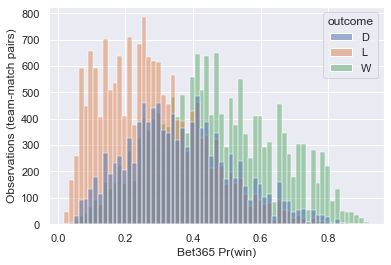

In [8]:
sns.histplot(data=d, x='B365_PrW', hue='outcome'); 
plt.xlabel('Bet365 Pr(win)'); 
plt.ylabel('Observations (team-match pairs)'); 

In [9]:
f_outcome(dat)
tab = dat[dat.home].groupby('outcome')['B365H'].mean().to_frame('Bet 365 Odds')
tab.loc[['L', 'D', 'W']].round(2)

,Bet 365 Odds
outcome,
L,3.54
D,2.60
W,2.08


This illustrates that if we compute the probabilities 

In [10]:
tab['inv_odds'] = 1/tab['Bet 365 Odds']
overround = tab['inv_odds'].sum()
tab['probs'] = tab['inv_odds'] / overround

print(f'Bet 365 avg. overround across all matches: {overround: 5.2%}')
tab.loc[['L', 'D', 'W']].round(3)

Bet 365 avg. overround across all matches:  114.93%


,Bet 365 Odds,inv_odds,probs
outcome,,,
L,3.537,0.283,0.246
D,2.599,0.385,0.335
W,2.075,0.482,0.419
